# CNNs and RNNs

In [1]:
import numpy as np

import keras as K
from keras.datasets import cifar10, mnist


2024-05-08 19:38:29.599503: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 19:38:30.342758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, np.min(y_train), np.max(y_train))
print(x_train.dtype, np.min(x_train), np.max(x_train))

(50000, 32, 32, 3) (50000, 1) 0 9
uint8 0 255


We have 50000 images with 32x32 resolution and three channels (RGB), each with a class label in {0, 1, ..., 9}.

(-0.5, 31.5, 31.5, -0.5)

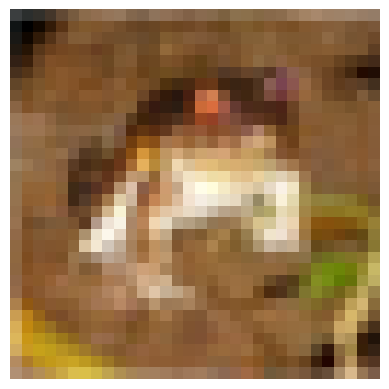

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
plt.axis('off')

## Convolutional Neural Networks
![conv.png](../_static/img/conv.png)
As you may know, CNNs represent a really good candidate for performing tasks in Computer Vision.

A Convolutional block (for images) is made up of:

1. A 2D convolutional filter (`K.layers.Conv2D`);
2. [_Optional_] A batch normalization layer (`K.layers.BatchNormalization`);
3. A pooling layer (`K.layers.MaxPooling2D`, `K.layers.AveragePooling2D`, ...);
4. An activation function (`K.layers.Activation`)

Finally, a CNN has a Dense layer which predicts the label upon flattening of the output of the previous convolutional block. Optionally, this layer is equipped with Dropout as regularizer.

In [4]:
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation
from keras.layers import Flatten, Dense

help(Conv2D)

Help on class Conv2D in module keras.src.layers.convolutional.conv2d:

class Conv2D(keras.src.layers.convolutional.base_conv.BaseConv)
 |  Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |
 |  2D convolution layer.
 |
 |  This layer creates a convolution kernel that is convolved with the layer
 |  input over a single spatial (or temporal) dimension to produce a tensor of
 |  outputs. If `use_bias` is True, a bias vector is created and added to the
 |  outputs. Finally, if `activation` is not `None`, it is applied to the
 |  outputs as well.
 |
 |  Args:
 |      filters: int, the dimension of the output space (the number of filters
 |          in the convolution).
 |      kernel_size: int or tuple/lis

Implement a CNN which performs the classification task on CIFAR10.

In [9]:
from os import name


model = K.Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), name='conv1'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3, 3), name='conv2'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), name='conv3'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), name='conv4'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # At this point the image is down to 2x2 with 64 channels
    # I use the 1x1 convolution trick to obtain a final representation
    # of the size I want, imposing loose connectivity.
    # Basically I impose sparse connectivity and shared weights on what 
    # would be the 1st hidden layer of the fully connected part
    # I spare a lot of parameters, and the final output of the convolution has
    # the size I want

    Conv2D(128, (1, 1), name='1x1conv'),
    Activation('relu'),

    # Just to give an idea:
    # Without 1x1 convolution: 2*2*64 = 256, 256*128 = 32768
    # With 128 filters: 2*2*128 = 512, 128*128 = 16384, 16384+512 = 16896

    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(10),
    BatchNormalization(),
    Activation('softmax')
])

/home/andrea/anaconda3/envs/ML-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


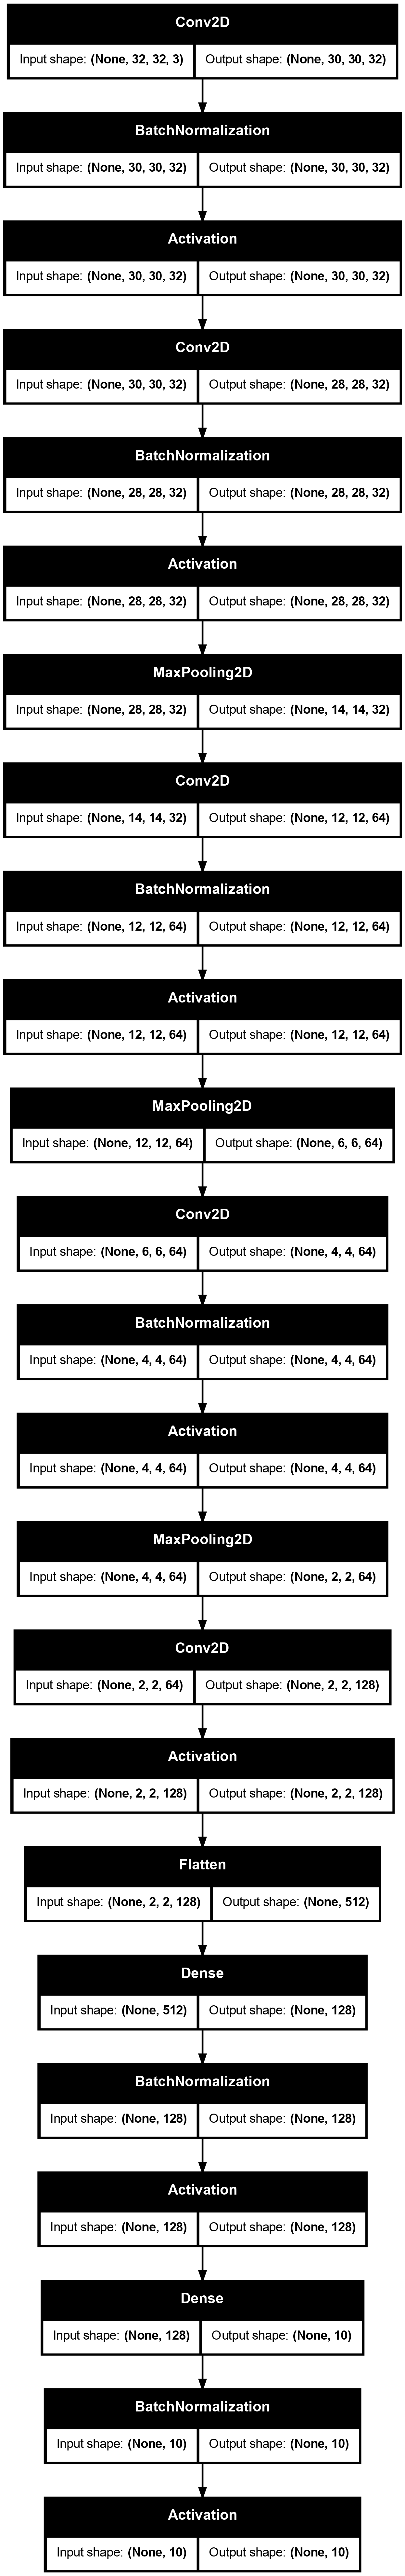

In [10]:
K.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(
    optimizer=K.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [12]:
early_stopping = K.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
model.fit(x_train, y_train, epochs=500, batch_size=1000, validation_split=0.2)

Epoch 1/500


I0000 00:00:1715193485.933405    8258 service.cc:145] XLA service 0x74800801c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715193485.933438    8258 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-08 20:38:06.017890: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-08 20:38:06.370529: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


: 

In [ ]:
metrics = model.evaluate(x_test, y_test)
print(metrics)

# Recurrent Models

Keras offers off-the-shelf tools for implementing also recurrent models easily. It provides interfaces for creating [``SimpleRNN``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)s, [``LSTM``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)s, [``GRU``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)s.

A recurrent model is made up of:

1. $n$ recurrent layers, optionally interleaved by dropout layers;
2. A Dense layer for performing the prediction. 

In [ ]:
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional

help(LSTM)

Implement a Recurrent model for performing classification on MNIST (how do you classify images with a RNN?)

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data(path='ds')